# Preperation

In [2]:
import numpy as np
from astropy.time import Time
import matplotlib.pyplot as plt
from astroquery.simbad import Simbad
from datetime import datetime
import pytz
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import calendar
from matplotlib.patches import Ellipse
from multiprocessing import Pool

In [3]:
#Longitude of the observetory in dms
d_1=12
m_1=00
s_1=57

#Latitude of the observetory in dms
d_2=48
m_2=40
s_2=54


In [ ]:
def dms_to_deg(d: float, m: float, s: float) -> float:
    """ This function takes coordinates in the format of degree:minute:second and calculates into decimal degrees.
    
    Parameters
    ----------
    d : float, Degrees
    m : float, Minutes
    s : float, Seconds
    
    :return (float) degrees: d:m:s in decimal degrees"""
    if d == 0:
        degrees =(np.abs(d) + m/60 + s/3600)
    else:
        degrees = (np.abs(d) + m/60 + s/3600)* np.sign(d)
    return degrees

Lon = dms_to_deg(d_1,m_1,s_1)
Lat = dms_to_deg(d_2,m_2,s_2)

def deg_to_dms(degrees: float) -> tuple[int, int, float]:
    """ This function takes coordinates in the format of decimal degrees and calculates into degree:minute:second.
    
    Parameters
    ----------
    degrees : float, Angle in degrees
    
    Returns
    ----------
    d : int, Degrees
    m : int, Minutes
    s : float, Seconds
    """
    deg=np.abs(degrees)
    d=np.round(np.floor(deg)*degrees/deg,0)
    m=np.round(np.floor(((deg-np.abs(d))*60)),0)
    s=np.round(((deg-np.abs(d)-(m/60))*3600),2)
    return d,m,s

2.6568472222222224
2.0 39.0 24.65


In [ ]:
def hms_to_deg(h: float, m: float, s: float) -> float:
    """ This function takes coordinates in the format of hours:minute:second and calculates into decimal degrees.
    Parameters
    ----------
    h : float, Hours
    m : float, Minutes
    s : float, Seconds

    Returns
    ----------
    degrees : float, h:m:s in decimal degrees
    """
    if h == 0:
        degrees = 15*(np.abs(h) + m/60 + s/3600)
    else:
        degrees = 15*(np.abs(h) + m/60 + s/3600)*np.sign(h)
    return degrees

def H_to_hms(H: float) -> tuple[int, int, float]:
    """ This function takes coordinates in the format of decimal hours and calculates into hours:minutes:seconds.
    
    Parameters
    ----------
    H : float, Hours
        
    Returns
    ----------
    h : int, Hours
    m : int, Minutes
    s : float, Seconds
    """
    h=np.floor(H)
    m=np.floor((H-h)*60)
    s=np.round((H-h-(m/60))*3600,2)
    return h,m,s

In [ ]:
def deg_to_rad(degrees: float) -> float:
    """This function takes degrees and calculates into radians.
    
    Parameters
    ----------
    degrees : float, Angle in degrees
    
    Returns
    ----------
    rad : float, Angle in radians
    """
    rad = degrees * np.pi/180
    return rad

def rad_to_deg(rad: float) -> float:
    """This function takes radians and calculates into degrees.
    
    Parameters
    ----------
    rad : float, Angle in radians

    Returns
    ----------
    degrees : float, Converted angle
    """
    degrees = rad * 180/np.pi
    return degrees


In [7]:
def earth_rotation_angle(zeit_jd):
    D_U = zeit_jd-2451545.0
    theta_0 = 360 * (0.7790572732640 + 1.00273781191135448*D_U)
    theta = theta_0 % 360
    return theta

In [8]:
def rotation_matrix_z(angles):
    if isinstance(angles, (int, float)):
        angles = [angles]
    matrices = []
    for t_p in angles:
        R_z = np.array([[np.cos(t_p), np.sin(t_p), 0],[-np.sin(t_p), np.cos(t_p), 0],[0, 0, 1]])
        matrices.append(R_z)
    return matrices

In [9]:
pi=np.pi

def rotation_matrix_y(phi):
    R_y = np.array([[np.sin(phi),0,-np.cos(phi)],[0,1,0],[np.cos(phi),0,np.sin(phi)]])
    return R_y
    
R_y=rotation_matrix_y(deg_to_rad(Lat))
diag = np.array([[-1,0,0],[0,1,0],[0,0,1]])

In [ ]:
def azimut_hoehe(zeit_jd,ra_deg,dec_deg):
    """This function takes radians and calculates into degrees.
    
    Parameters
    ----------
    rad : float, Angle in radians

    Returns
    ----------
    degrees : float, Converted angle
    """    
    ra=deg_to_rad(ra_deg)
    dec=deg_to_rad(dec_deg) 
    ERA = deg_to_rad(earth_rotation_angle(zeit_jd)) + deg_to_rad(Lon)
    R_z = rotation_matrix_z(ERA)
    R = np.array([[np.cos(ra)*np.cos(dec)],[np.sin(ra)*np.cos(dec)],[np.sin(dec)]])
    M = diag@(R_y@(R_z@R))
    H = np.arcsin(M[:,2,:])
    A = np.arctan2(M[:,1,:],M[:,0,:])
    H_deg = rad_to_deg(H)
    A_deg = rad_to_deg(A)
    return A_deg, H_deg  

In [11]:
def zenith_distance(Alltitude):
    z=90-Alltitude
    return z

# Creating List of Objects for Messier, NGC and IC

In [ ]:
# Clear cache to avoid stale results
Simbad.clear_cache()

# Configure Simbad query to include required fields
custom_simbad = Simbad()
custom_simbad.add_votable_fields('main_id', 'ra', 'dec', 'V', 'dim', "ids","morph_type")

Messier_list = ["M" + str(i) for i in range(1,109)]
NGC_list = ["NGC" + str(i) for i in range(1,7841)]
IC_list = ["IC" + str(i) for i in range(1,5387)]

def extract_messier_name(object_ids):
    """Checks if an object's ID list contains a Messier name.

    Calls an object -> splits the name using the delimiter '|' used by SIMBAD
    -> checks if there is an "Messier" or "M " name in the list -> filters the object out of the list

    Parameters
    ----------
    object_ids : list, List of object IDs
    """
    if object_ids is None:
        return None  # No IDs available

    for id_str in object_ids.split('|'):  # SIMBAD separates IDs with '|'
        id_str = id_str.strip()
        if id_str.startswith("Messier") or id_str.startswith("M "):
            return id_str  # Return the first found Messier name
    
    return None

def extract_NGC_name(object_ids):
    """Check if an object's ID list contains a NGC name.
    
    Calls an object -> splits the name using the delimiter '|' used by SIMBAD
    -> strips the white spaces -> checks if there is an "NGC" -> filters the object out of the list
    
    Parameters
    ----------
    object_ids : list, List of object IDs
    """
    if object_ids is None:
        return None  # No IDs available

    for id_str in object_ids.split('|'):  # SIMBAD separates IDs with '|'
        id_str = id_str.strip() # Extra Info: NGC always has one space between NGC XXXX. However, if the number is less than four digits, spaces are added to compensate, so that NGC  XXX is in the same position as NGC   XX and NGC    X
        if id_str.startswith("NGC"):
            return id_str.replace(" ", "")  # Return the first found NGC name
    
    return None

def extract_IC_name(object_ids):
    """Check if an object's ID list contains a IC name.
    
    Calls an object -> splits the name using the delimiter '|' used by SIMBAD
    -> strips the white spaces -> checks if there is an "IC" -> filters the object out of the list
    
    Parameters
    ----------
    object_ids: list, List of object IDs
    """
    if object_ids is None:
        return None  # No IDs available

    for id_str in object_ids.split('|'):  # SIMBAD separates IDs with '|'
        id_str = id_str.strip() # Extra Info: IC always has one space between IC XXXX. However, if the number is less than four digits, spaces are added to compensate, so that IC  XXX is in the same position as IC   XX and IC    X
        if id_str.startswith("IC"):
            return id_str.replace(" ", "") # Return the first found NGC name
    
    return None

 
def Simbad_extraction(objects, name, batch_size=200):
    """This function conducts a query of SIMBAD. It pulls the data for RA, DEC, dimensions, flux and morphological type. Then it creates a list of all objects. The list of objects is saved as ```[name].txt```
    
    Parameters
    ----------
    objects : list, A list of all objects
    name : str, Name of list to be saved as `[name].txt`
    batch_size : int, size over which loop iterates

    Returns
    ----------
    data_npar : 6darray, NumPy array consisting of data of the filtered objects
    """
    data = []

    # Creates a batch of objects which are then queried. After the batch is complete, new batch is created.
    for i in range(0, len(objects), batch_size):
        batch = objects[i:i + batch_size]
        result_table = custom_simbad.query_objects(batch)

        if result_table is None:
            print(f"No results found for batch {i // batch_size + 1}")
            continue

        for j, obj in enumerate(batch):
            try:
                # Extract RA and DEC
                ra_values = result_table['ra'][j]
                dec_values = result_table['dec'][j]

                magnitude = result_table["V"][j] if "V" in result_table.colnames else None
                
                # Extract galaxy dimensions (major/minor axis)
                major_axis = result_table["galdim_majaxis"][j] if "galdim_majaxis" in result_table.colnames else None
                minor_axis = result_table["galdim_minaxis"][j] if "galdim_minaxis" in result_table.colnames else None

                matched_ID = result_table["ids"][j] if "ids" in result_table.colnames else None
                messier_name = extract_messier_name(matched_ID)
                NGC_name = extract_NGC_name(matched_ID)
                IC_name = extract_IC_name(matched_ID)

                morph_type = result_table["morph_type"][j] if "morph_type" in result_table.colnames else None
                if np.ma.is_masked(ra_values) or np.ma.is_masked(dec_values):
                    continue

                # Filter for name lists. If one of these is true, it means that an object has double names and is filtered out of the list. For more infos see documentation of the functions NGC_name, messier_name and IC_name.
                if obj in NGC_list:
                    if NGC_name != obj:
                        continue
                    if messier_name:
                        continue
                elif obj in IC_list:
                    if IC_name != obj:
                        continue

                # Append only if all values exist
                data.append((obj, ra_values, dec_values, magnitude, major_axis, minor_axis, morph_type))

            except Exception as e:
                print(f"Error processing {obj}: {e}")

    data_npar = np.array(data, dtype=object)

    # Saves the numpy array as a file under the name [name].txt as provided in the function
    np.savetxt(name, data_npar)
    
    return data_npar

def load_variable_column_file(filename: str) -> Array:
    """
    This function loads a ```.txt``` file object lists. Because of the function :obj:`Simbad_extraction` some objects do not have values for their morphological type. This function pads those cells and adds a `NaN` so that the resulting table is consistent.

    Parameters
    ----------
    filename : str, Name of the file in form of `[NAME_OF_FILE].txt`

    Returns
    ----------
    data_padded_nparr : 7darray str, Padded data from `.txt` file as NumPy array with elements as strings.
    """

    with open(filename, "r") as f:
        lines = [line.strip().split() for line in f if not line.startswith("#")]

    # Find the maximum number of columns in the file
    max_cols = max(len(line) for line in lines)

    # Ensure all rows have the same number of columns by padding missing values
    data_padded = [line + ["NaN"] * (max_cols - len(line)) for line in lines]

    # Convert to NumPy array
    data_padded_nparr = np.array(data_padded, dtype=str)
    return data_padded_nparr

messier_arr = load_variable_column_file("Messier.txt")
NGC_arr = load_variable_column_file("NGC.txt")
IC_arr = load_variable_column_file("IC.txt")


data_arr = np.vstack((messier_arr,NGC_arr,IC_arr))

In [ ]:
Only_Galaxies = 0

def Galaxies(Objects):
    """
    This function filters a list of objects by the condition of "Galaxy".

    Parameters
    ----------
    Objects : list, List of objects

    Returns
    ----------
    Objects_gal : array str, List of all galaxies
    """
    no_gal = []

    for n in range(len(Objects)):
        if Objects[n,-1] == "NaN" :
            no_gal.append(n)
        else:
            continue

    Objects_gal = np.delete(Objects,no_gal,0)

    return Objects_gal

if Only_Galaxies == 1:
    data_arr = Galaxies(data_arr)
else:
    data_arr = np.vstack((messier_arr,NGC_arr,IC_arr))

In [ ]:
fl = 750
Ap = 150
Ps = 4.30
x_ax = 5184
y_ax = 3456
Dia = np.sqrt((x_ax)**2+(y_ax)**2)

def Fov(L):
    return (206.2648 * (Ps/fl) * L)/60


FOV = Fov(Dia)

x_FOV = Fov(x_ax)
y_FOV = Fov(y_ax)

min_frac = 0.1

remove_nan = 1

def safe_convert(val):
    try:
        return float(val)
    except ValueError:
        return np.nan

def ratio(object_arr):

    maj_ax = np.array([safe_convert(x) for x in object_arr[:,4]])
    min_ax = np.array([safe_convert(x) for x in object_arr[:,5]])

    mask = (np.isnan(maj_ax) | (maj_ax>=min_frac*x_FOV)) &(np.isnan(min_ax) |  (min_ax>=min_frac*y_FOV))

    if remove_nan:
        mask = mask & ~np.isnan(maj_ax) & ~np.isnan(min_ax)

    return object_arr[mask]

data_FOV = ratio(data_arr)

def Ratio(object_row):
    Diagonal = np.sqrt(float(object_row[4])**2+float(object_row[5])**2)
    return Diagonal/FOV

In [15]:
# Alltitude maximal if ra_deg = ERA + Lambda

def min_zenith_distance(dec_deg):
    dec = deg_to_rad(dec_deg)
    phi = deg_to_rad(Lat)
    #print(phi,dec)
    H_ex_1 = np.arcsin(np.cos(phi-dec))
    #H_ex_2 = np.arcsin(np.cos(phi+dec+np.pi)+np.cos(phi-dec+np.pi))
     #np.arcsin((-2*np.cos(dec+phi)+2*np.cos(dec-phi)+np.cos(dec+phi)+np.cos(-dec+phi)+np.cos(dec-phi)+np.cos(-dec-phi))/4)
    H_ex_2 = np.arcsin((-2*np.cos(dec+phi)+2*np.cos(dec-phi)+np.cos(dec+phi+np.pi)+np.cos(-dec+phi+np.pi)+np.cos(dec-phi+np.pi)+np.cos(-dec-phi+np.pi))/4)
    H_EX_1 = rad_to_deg(H_ex_1)
    H_EX_2 = rad_to_deg(H_ex_2)
    #print(H_EX_1,H_EX_2)
    if H_ex_1 > H_ex_2:
        z = zenith_distance(H_EX_1)
    else:
        z = zenith_distance(H_EX_2)
    return z

#arcsin((-2*cos(dec+phi)+2*cos(dec-phi)+cos(dec+phi+pi)+cos(-dec+phi+pi)+cos(dec-phi+pi)+cos(-dec-phi+pi))/4)

min_zen_dis = []

for n in range(len(data_FOV[:,1])):
    z = min_zenith_distance(data_FOV[n,2].astype(float))
    min_zen_dis.append(z)
Z_s = np.array(min_zen_dis)

#deleting all Objects which never reach 60° 

indices_to_del = []

for n in range(len(Z_s)):
    if float(Z_s[n].item()) >40:
        indices_to_del.append(n)
Z_g = np.delete(Z_s,indices_to_del,0)
#print(Z_g)
data_min_h = np.delete(data_FOV, indices_to_del,0)




# Time

In [16]:
delta_T = 8/24
p = int(delta_T*1440 + 1)
print("t:" ,delta_T)
#Number of minutes in delta_t is 445

T = np.linspace(0,delta_T,p)

#deleting all Objects from the array which have an Elevation of 30° for less than 2 hours of the 1st Praktikum night 



cest_tz = pytz.timezone('Europe/Berlin')  
dt = datetime(2025, 3, 1, 19, 0, 0)  

cest_time = cest_tz.localize(dt)

utc_time = cest_time.astimezone(pytz.utc)
print("time",utc_time) 

Zeit_Nacht = Time(utc_time).jd
print(Zeit_Nacht)

Zeit_Nacht_T = Zeit_Nacht + T
keep = []
more_del=[]

#Baseline alltitude above which DSO should be for an extended period. 
m = 30
#Number of Minutes DSO should be above the Baseline
num = 120


for n in range(len(data_min_h[:,0])):
    if np.sum((azimut_hoehe(Zeit_Nacht_T,data_min_h[n,1].astype(float),data_min_h[n,2].astype(float)))[1] > m) >=num:
        keep.append(n) 
    else: 
        more_del.append(n)

data_fin = np.delete(data_min_h,more_del,0)

minutes = np.linspace(0,p,p)
start_time = datetime.strptime("19:00", "%H:%M")
time_data = [start_time + timedelta(minutes=int(minute)) for minute in minutes]

#Printing the resulting list and Plotting the Elevation in relation to the time on the night of the 1st day of the Praktikum

print('Objects which fit all Criterea:', ', '.join(map(str,data_fin[:,0])))


t: 0.3333333333333333
time 2025-03-01 18:00:00+00:00
2460736.25
Objects which fit all Criterea: M3, M13, M34, M35, M36, M37, M38, M44, M45, M52, M53, M63, M67, M81, M86, M92, M94, M101, M106, NGC129, NGC188, NGC225, NGC381, NGC457, NGC663, NGC743, NGC752, NGC869, NGC884, NGC886, NGC957, NGC1027, NGC1245, NGC1333, NGC1342, NGC1513, NGC1528, NGC1545, NGC1579, NGC1582, NGC1647, NGC1662, NGC1664, NGC1708, NGC1750, NGC1758, NGC1778, NGC1807, NGC1817, NGC1893, NGC1931, NGC2126, NGC2169, NGC2224, NGC2234, NGC2264, NGC2281, NGC2395, NGC2403, NGC5466, NGC7762, NGC7822, IC342, IC348, IC443, IC1805, IC1848


# Advanced Viewer

In [17]:
data_30 = []

for n in range(len(data_fin[:,0])):
    N = np.sum((azimut_hoehe(Zeit_Nacht_T,data_fin[n,1].astype(float),data_fin[n,2].astype(float)))[1] > m)
    data_30.append(N) 

data_30_arr = np.array(data_30, dtype = float)


sorted_data_30 = np.append(data_fin, data_30_arr[:, None], axis=1)


final_best = np.array(sorted(sorted_data_30, key=lambda x: ( float(x[-1]), float(x[4])), reverse=True),dtype = object)



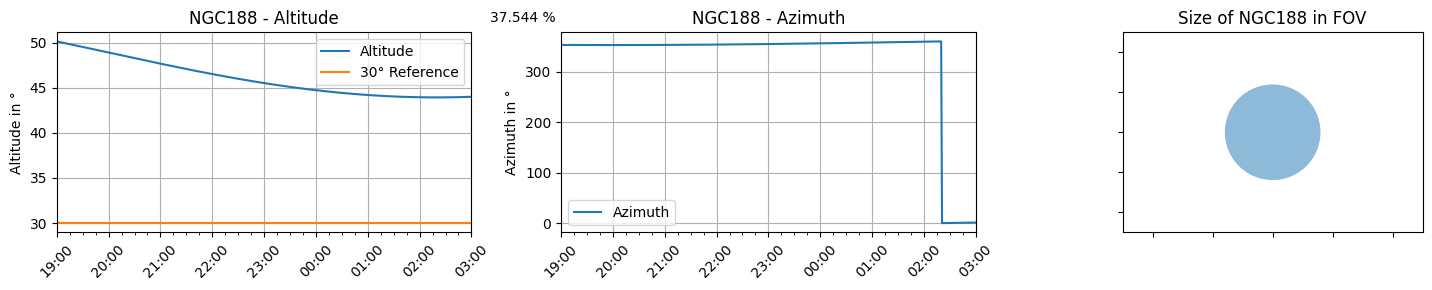

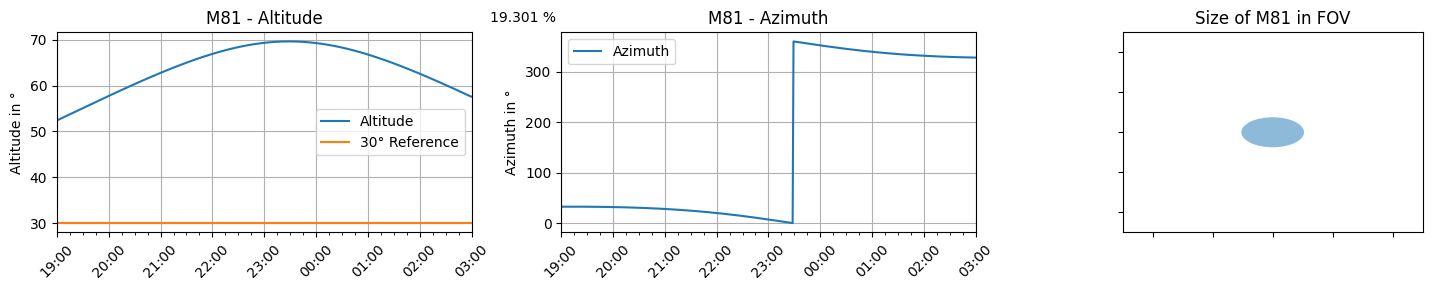

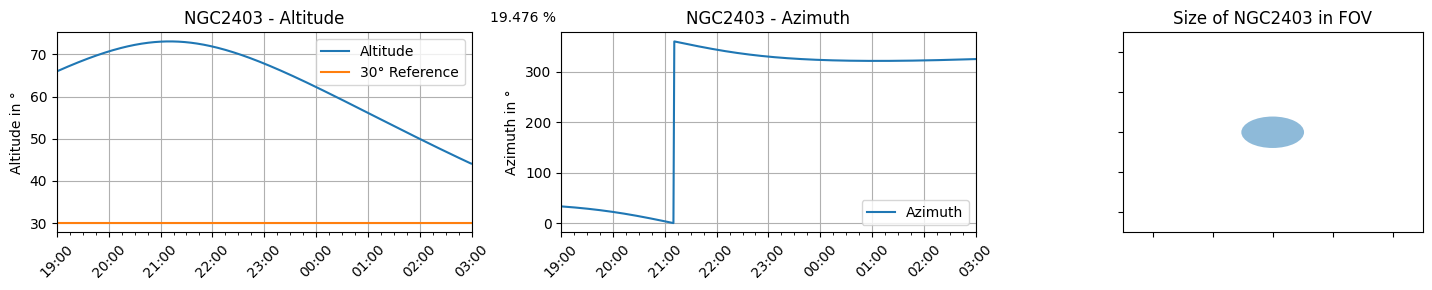

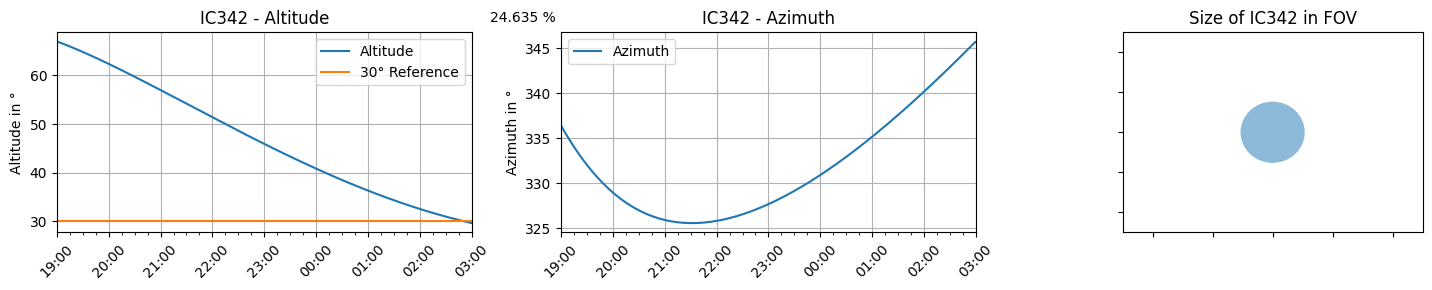

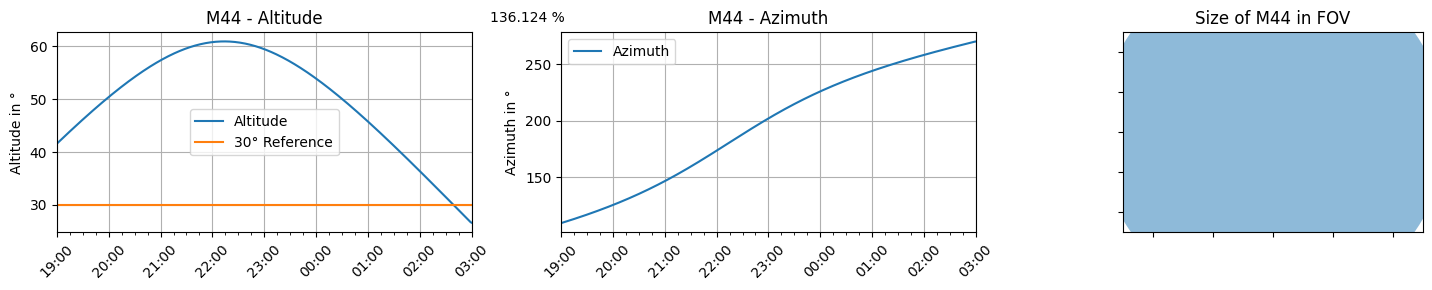

In [18]:
k = min(5, len(final_best[:, 0])) 

for n in range(k):
    H = (azimut_hoehe(Zeit_Nacht_T,float(final_best[n,1]),float(final_best[n,2])))[1]
    a = (azimut_hoehe(Zeit_Nacht_T,float(final_best[n,1]),float(final_best[n,2])))[0]
    A=[x + 360 if x<0 else x for x in a]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))

   # Plot Altitude (H) on the first axis
    ax1.plot(time_data, H, label='Altitude')
    ax1.plot(time_data, np.linspace(30, 30, p), label='30° Reference')
    ax1.set_title(f"{final_best[n, 0]} - Altitude")
    ax1.set_ylabel('Altitude in °')
    ax1.set_xlim(datetime.strptime("19:00", "%H:%M"), datetime.strptime("03:00", "%H:%M") + timedelta(days=1))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax1.xaxis.set_minor_locator(mdates.MinuteLocator(interval=15))
    ax1.legend()
    ax1.grid()

    
    
     # Plot Azimuth (A) on the second axis
    ax2.plot(time_data, A,"-",label='Azimuth')
    ax2.set_title(f"{final_best[n, 0]} - Azimuth")
    ax2.set_ylabel('Azimuth in °')
    ax2.set_xlim(datetime.strptime("19:00", "%H:%M"), datetime.strptime("03:00", "%H:%M") + timedelta(days=1))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax2.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax2.xaxis.set_minor_locator(mdates.MinuteLocator(interval=15))
    ax2.legend()
    ax2.grid()



    ellipse = Ellipse((0,0),width=float(final_best[n,4])/x_FOV,height=float(final_best[n,5])/y_FOV,angle = 0, alpha = 0.5)


    ax3.add_patch(ellipse)

    ax3.set_xlim(-0.5,0.5)
    ax3.set_ylim(-0.5,0.5)
    ax3.set_title(f"Size of {final_best[n,0]} in FOV")
    ax3.set_aspect(aspect=y_ax/x_ax)

    ax3.set_xticklabels([])
    ax3.set_yticklabels([])

    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

    fig.text(0.33,0.91,f"{np.float64(Ratio(final_best[n]))*100:.3f} %")

    plt.tight_layout()
    plt.show()


# Time Viewer

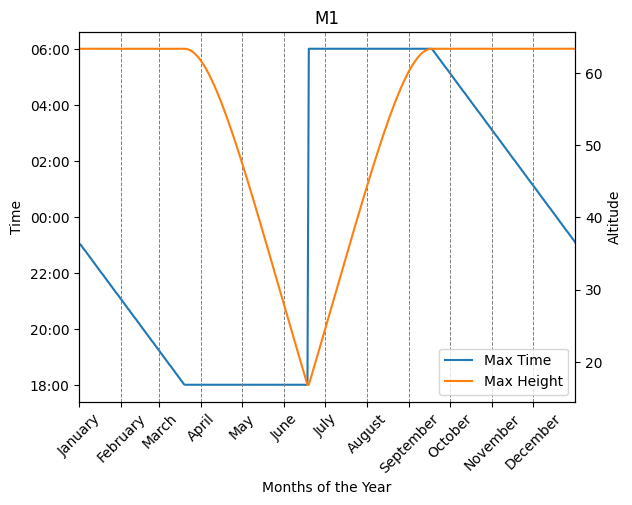

In [19]:
object_map = {name: idx for idx, name in enumerate(data_arr[:, 0])}

def get_row_by_name(name):
    """Get the row index for a given object name."""
    return object_map.get(name, None)


dt_1 = datetime(2025, 1, 1, 18, 0, 0)  
cest_tz = pytz.timezone("Europe/Berlin")  
cest_time_1 = cest_tz.localize(dt_1)

utc_time_1 = cest_time_1.astimezone(pytz.utc)
# print("utc time", utc_time_1)

# Use astropy to get Julian Date
Zeit_start = Time(utc_time_1).jd
# print(Zeit_start)

day_arr = np.linspace(0, 0.5, 1001)
max_time = []
max_height = []


object_name = "M1"  # Replace with the desired name
object_idx = get_row_by_name(object_name)

if object_idx is not None:
    for n in range(365):
        Day = Zeit_start + day_arr + n
        H_object = (azimut_hoehe(Day, data_arr[object_idx, 1].astype(float), data_arr[object_idx, 2].astype(float)))[1]
        max_time_loop = np.argmax(H_object)
        max_loop = np.max(H_object)
        max_height.append(max_loop)
        time_loop = np.linspace(0, 12, 1001)[max_time_loop]
        max_time.append(time_loop)

    max_time_arr = np.array(max_time)
    max_height_arr = np.array(max_height)
    year = np.linspace(1, 365, 365)

    def convert_time(value):
        """Converts time (0-12) to 18:00-6:00 format."""
        hours = (value + 18) % 24
        return f"{int(hours):02d}:00"

    month_days = [0] + np.cumsum([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]).tolist()
    month_labels = [calendar.month_name[i] for i in range(1, 13)]

    # Plotting
    fig, ax1 = plt.subplots()
    line1, = ax1.plot(year, max_time_arr, color='#1f77b4', label="Max Time")
    ax1.set_ylabel("Time")
    ax1.set_xlabel("Months of the Year")
    ax1.set_xlim(0,365)
    ax1.set_title(object_name)

    ax1.set_yticks(np.linspace(0, 12, 7))  
    ax1.set_yticklabels([convert_time(tick) for tick in np.linspace(0, 12, 7)])  

    ax1.set_xticks(month_days[:-1])  
    ax1.set_xticklabels(month_labels)

    for day in month_days[1:-1]:  # Skip the first (0) and last (end of the year)
        ax1.axvline(x=day, color='gray', linestyle='--', linewidth=0.7)

    ax2 = ax1.twinx()
    line2, = ax2.plot(year, max_height_arr, color='#ff7f0e', label="Max Height")
    ax2.set_ylabel("Altitude")


    # ax1.set_ylim(-0.5,12.5)
    # ax2.set_ylim(0,90)


    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    plt.legend(lines, labels, loc="lower right")  
    plt.show()
else:
    print(f"Object '{object_name}' not found in data.")


# Map

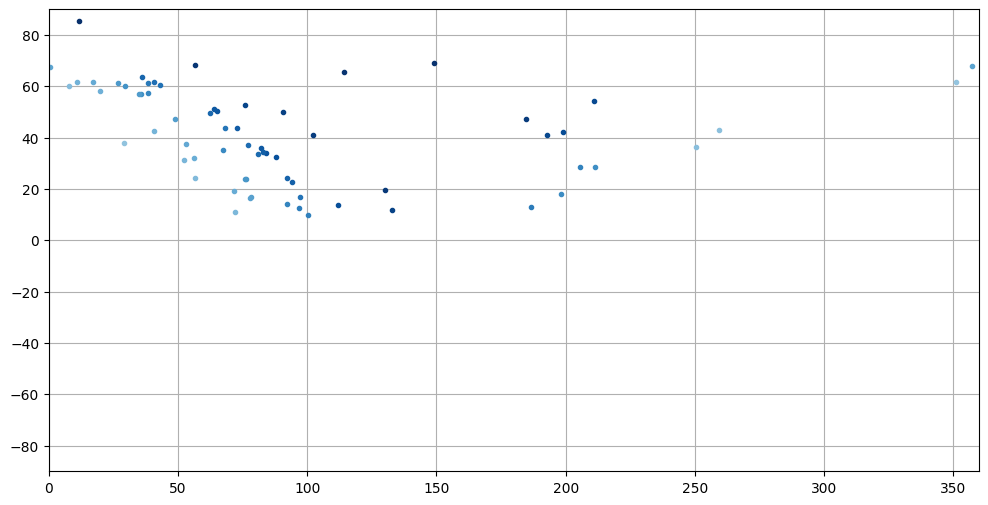

In [20]:
def maping(objects):
    
    fig,ax = plt.subplots(figsize=(12,6))

    num_points = len(objects)  
    colors = plt.cm.Blues(np.linspace(1, 0.4, num_points))  
    

    for n in range(num_points):
        ax.plot(
            float(objects[n, 1]), 
            float(objects[n, 2]), 
            ".", 
            color=colors[n], 
            label=objects[n, 0] if n < 10 else ""  
        )


    ax.set_xlim(0,360)
    ax.set_ylim(-90,90)
    ax.grid()
    plt.show


maping(final_best)

